In [80]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
# load data
df2009_2010 = pd.read_csv("year2009-2010.csv", encoding="latin1")
df2010_2011 = pd.read_csv("year2010-2011.csv", encoding="latin1")

# rename invoice column
df2009_2010.rename(columns={df2009_2010.columns[0]: 'Invoice'}, inplace=True)
df2010_2011.rename(columns={df2010_2011.columns[0]: 'Invoice'}, inplace=True)

# remove non-customer transactions
df2010_2011 = df2010_2011.dropna(subset=['Customer ID'])
df2009_2010 = df2009_2010.dropna(subset=['Customer ID'])

#combine duplicate transactions
df2009_2010 = df2009_2010.groupby(['Invoice', 'StockCode', 'Customer ID'], as_index=False).agg({
    'Quantity': 'sum',
    'InvoiceDate': 'first',
    'Price': 'first',
    'Description': 'first',  
    'Country': 'first'       
})
df2010_2011 = df2010_2011.groupby(['Invoice', 'StockCode', 'Customer ID'], as_index=False).agg({
    'Quantity': 'sum',
    'InvoiceDate': 'first',
    'Price': 'first',
    'Description': 'first',  
    'Country': 'first'       
})

# add time features 
df2009_2010['InvoiceDate'] = pd.to_datetime(df2009_2010['InvoiceDate'])
df2009_2010['TimeOfDay'] = df2009_2010['InvoiceDate'].dt.hour
df2009_2010['DayOfWeek'] = df2009_2010['InvoiceDate'].dt.day_name()
df2010_2011['InvoiceDate'] = pd.to_datetime(df2010_2011['InvoiceDate'])
df2010_2011['TimeOfDay'] = df2010_2011['InvoiceDate'].dt.hour
df2010_2011['DayOfWeek'] = df2010_2011['InvoiceDate'].dt.day_name()

# calculate session duration
df2009_2010['SessionDuration'] = df2009_2010.groupby('Customer ID')['InvoiceDate'].diff().dt.total_seconds()
df2010_2011['SessionDuration'] = df2010_2011.groupby('Customer ID')['InvoiceDate'].diff().dt.total_seconds()

# calculate total sales amount
df2009_2010['TotalSalesAmount'] = df2009_2010['Quantity'] * df2009_2010['Price']
df2010_2011['TotalSalesAmount'] = df2010_2011['Quantity'] * df2010_2011['Price']

# revenue
df2009_2010['Revenue'] = df2009_2010['Quantity'] * df2009_2010['Price']
df2010_2011['Revenue'] = df2010_2011['Quantity'] * df2010_2011['Price']

# combine 2009-2010 and 2010-2011
df = pd.concat([df2009_2010, df2010_2011])

# split into purchases and returns
df_purchases = df[df['Quantity'] > 0]
df_returns = df[df['Quantity'] < 0]

In [ ]:
# list of countries in dataset
print(pd.DataFrame(sorted(df['Country'].unique()), columns=['Country']))
# countries by revenue
CountriesRevenue = df.groupby('Country')['Revenue'].sum().nlargest(5)
plt.figure(figsize=(12, 6))
CountriesRevenue.plot(kind='barh')
for index, value in enumerate(CountriesRevenue):
    plt.text(value, index, f'£{value:.2f}', va='center')
plt.title('Top 5 Countries by Revenue')
plt.xlabel('Revenue (£)')
plt.tight_layout()
plt.show()

In [ ]:
# visualize transactions by hour
HourlyTransactions = df.groupby('TimeOfDay')['Invoice'].count()
HourlyTransactions.plot(kind='line', marker='o')
plt.title('Number of Transactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# visualize number of sales made according to day of week
DailySales = df.groupby('DayOfWeek')['TotalSalesAmount'].sum()
DailySales.plot(kind='bar')
plt.title('Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# determine top products sold
TopProducts = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
TopProducts.plot(kind='barh')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Quantity Sold')
plt.tight_layout()
plt.show()

In [ ]:
# distribution of quantity (purchases only, under 50)
plt.hist(df_purchases[df_purchases['Quantity'] < 50]['Quantity'])
plt.title('Distribution of Quantity in Purchases')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# clustering customers by sales/quantity purchased
customer_data = df.groupby('Customer ID').agg({
    'Quantity' : 'sum',
    'TotalSalesAmount': 'sum',
}).reset_index()

scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['Quantity', 'TotalSalesAmount', ]])

# find best k with elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data_scaled)
    inertia.append(kmeans.inertia_)
    
# show elbow plot
plt.plot(range(1, 11), inertia, marker = 'o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# elbow at k = 4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# show clusters
sns.scatterplot(x='Quantity', y = 'TotalSalesAmount', hue = 'Cluster', data = customer_data, s = 100, alpha = 0.7)
plt.title(f'Customer Segmentation using K-Means Clustering (k={k})')
plt.xlabel('Total Quantity Purchased')
plt.ylabel('Total Sales Amount')
plt.legend(title='Cluster')
plt.show()

# average quantity and total sales by cluster
cluster_centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=['Quantity', 'TotalSalesAmount'])
print(cluster_centroids)

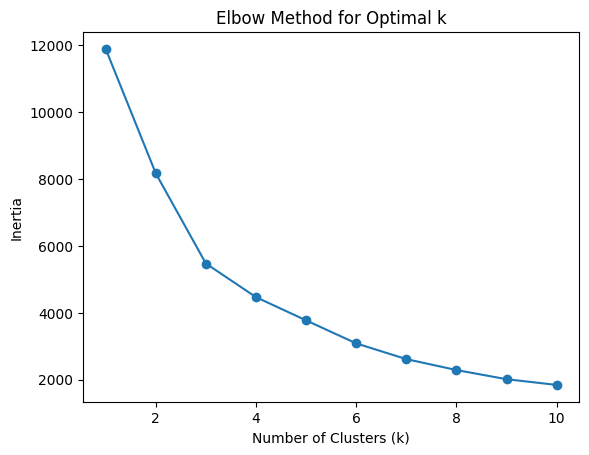

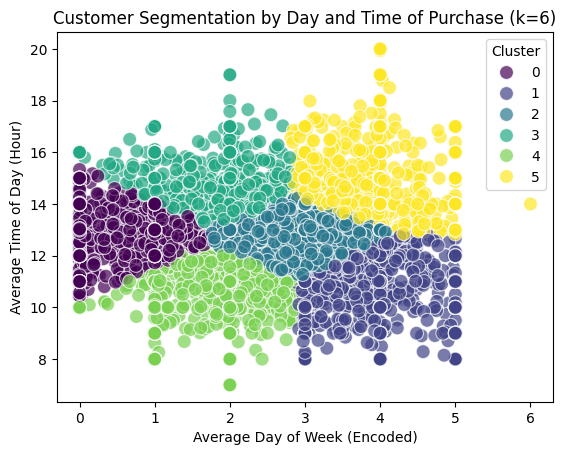

   DayOfWeek_Encoded  TimeOfDay DayOfWeek_Decoded
0           0.597604  12.870448            Monday
1           3.919853  10.730431          Thursday
2           2.825461  12.645565         Wednesday
3           1.808916  14.811358           Tuesday
4           1.826173  10.750618           Tuesday
5           3.890310  14.912293          Thursday


In [ ]:
# cluster customers by day of week and time of purchases

# map DayOfWeek to numerical values
day_mapping = {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6}
df['DayOfWeek_Encoded'] = df['DayOfWeek'].map(day_mapping)

customer_data = df.groupby('Customer ID').agg({
    'DayOfWeek_Encoded': 'mean',  # Use the mean of the encoded day for each customer
    'TimeOfDay': 'mean'           # Average purchase time of day
}).reset_index()

scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['DayOfWeek_Encoded', 'TimeOfDay']])

# find best k with elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data_scaled)
    inertia.append(kmeans.inertia_)

# show elbow plot
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# elbow at k = 6
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# show clusters
sns.scatterplot(
    x='DayOfWeek_Encoded', 
    y='TimeOfDay', 
    hue='Cluster', 
    data=customer_data, 
    palette='viridis', 
    s=100, alpha=0.7
)
plt.title(f'Customer Segmentation by Day and Time of Purchase (k={k})')
plt.xlabel('Average Day of Week (Encoded)')
plt.ylabel('Average Time of Day (Hour)')
plt.legend(title='Cluster')
plt.show()

# Decode cluster centers to original scale
cluster_centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_), 
    columns=['DayOfWeek_Encoded', 'TimeOfDay']
)
cluster_centroids['DayOfWeek_Decoded'] = cluster_centroids['DayOfWeek_Encoded'].round().map({v: k for k, v in day_mapping.items()})
print(cluster_centroids)
